# How to detect marine heatwave based on observational dataset

The marine heatwaves are anomalous warm water over the ocean. 
To detect the warm ocean water, sea surface temperature (SST) is usually used to define if there is any marine heatwave event. 

The following example is following the paper [Jacox et al., 2022](http://doi.org/10.1038/s41586-022-04573-9)


In [1]:
# if running google colab next line (uncomment the line) need to be executed to get the necessary backend pydap support in the later on code
# !pip install pydap

In [2]:
import warnings
import datetime
import xarray as xr
import numpy as np
# from dask.distributed import Client


In [3]:
opendap_mon_url = "https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.oisst.v2.highres/sst.mon.mean.nc"

In [4]:
ds_mon = xr.open_dataset(opendap_mon_url, engine='pydap', chunks={'time':12,'lon':-1,'lat':-1})

In [5]:
climo_start_yr = 2019             # determine the climatology/linear trend start year
climo_end_yr = 2020               # determine the climatology/linear trend end year

ds_mon_crop = ds_mon.where((ds_mon['time.year']>=climo_start_yr)&
                           (ds_mon['time.year']<=climo_end_yr),drop=True)

In [6]:
ds_mon_crop

<xarray.Dataset>
Dimensions:  (time: 24, lat: 720, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 2019-01-01 2019-02-01 ... 2020-12-01
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
Data variables:
    sst      (time, lat, lon) float32 dask.array<chunksize=(8, 720, 1440), meta=np.ndarray>
Attributes:
    Conventions:                     CF-1.5
    title:                           NOAA/NCEI 1/4 Degree Daily Optimum Inter...
    institution:                     NOAA/National Centers for Environmental ...
    source:                          NOAA/NCEI https://www.ncei.noaa.gov/data...
    References:                      https://www.psl.noaa.gov/data/gridded/da...
    dataset_title:                   NOAA Daily Optimum Interpolation Sea Sur...
    version:                         Version 2.1
    comment:                         Reynolds, et al.(2007) Daily High-Resolu...
    _NCProperties:                   version=2,netcdf=4.7.0,hdf5=1.10.5,
    DODS_EXTRA.Unlimited_Dimension:  time

In [7]:
ds_mon_climo = ds_mon_crop.groupby('time.month').mean()
ds_mon_anom = (ds_mon_crop.groupby('time.month')-ds_mon_climo).compute()

In [8]:
ds_mon_anom.sst

<xarray.DataArray 'sst' (time: 24, lat: 720, lon: 1440)>
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [ 0.00532258,  0.00532258,  0.00693548, ...,  0.00596774,
          0.00629032,  0.00516129],
        [ 0.00241935,  0.00274193,  0.00177419, ...,  0.00370967,
          0.00274193,  0.00290322],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
...
        [ 0.02583337,  0.02333331,  0.02299988, ...,  0.01999998,
          0.02166665,  0.02499998],
        [ 0.01749992,  0.01249993,  0.01049995, ...,  0.01033342,
          0.0126667 ,  0.01599991],
        [ 0.        ,  0.        ,  0.00849998, ...,  0.00516665,
          0.        ,  0.        ]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [ 0.00451612,  0.00467741,  0.00580645, ...,  0.00612903,
          0.00564516,  0.00419354],
        [ 0.00016129,  0.00177419,  0.00419354, ...,  0.00403225,
          0.00225806, -0.00096774],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2019-01-01 2019-02-01 ... 2020-12-01
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 12 1 2 3 4 5 6 7 8 9 10 11 12

In [9]:
########## Functions ######### 
# Function to calculate the 3 month rolling Quantile
def mj_3mon_quantile(da_data, mhw_threshold=90.):
    
    da_data_quantile = xr.DataArray(coords={'lon':da_data.lon,
                                            'lat':da_data.lat,
                                            'month':np.arange(1,13)},
                                    dims = ['month','lat','lon'])

    for i in range(1,13):
        if i == 1:
            mon_range = [12,1,2]
        elif i == 12 :
            mon_range = [11,12,1]
        else:
            mon_range = [i-1,i,i+1]

        da_data_quantile[i-1,:,:] = (da_data
                                 .where((da_data['time.month'] == mon_range[0])|
                                        (da_data['time.month'] == mon_range[1])|
                                        (da_data['time.month'] == mon_range[2]),drop=True)
                                 .quantile(mhw_threshold*0.01, dim = 'time', skipna = True))

    return da_data_quantile


In [10]:
%time da_mon_quantile = mj_3mon_quantile(ds_mon_anom.sst, mhw_threshold=90)

/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


CPU times: user 9min 2s, sys: 680 ms, total: 9min 2s
Wall time: 9min 2s


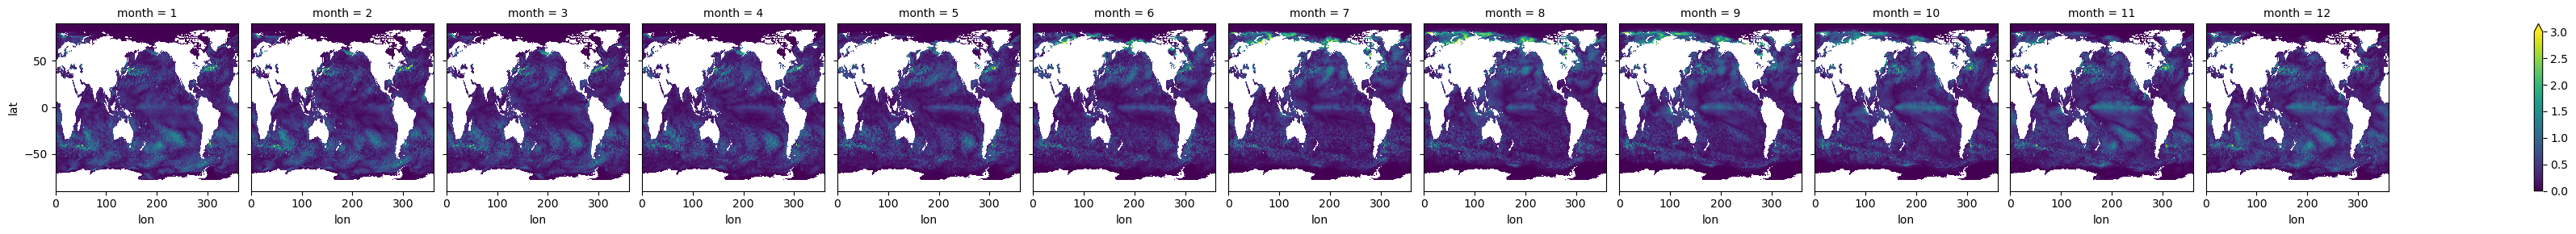

In [11]:
da_mon_quantile.plot(col='month',vmin=0,vmax=3)

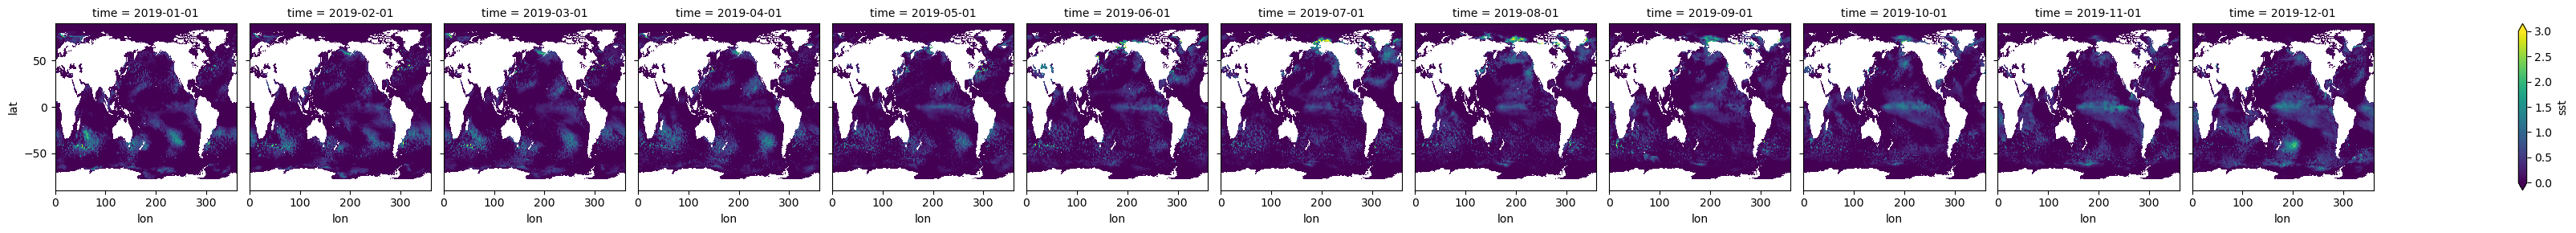

In [12]:
ds_mon_anom.sst.isel(time=slice(0,12)).plot(col='time',vmin=0,vmax=3)

In [13]:
da_mhw = ds_mon_anom.sst.where(ds_mon_anom.sst.groupby('time.month')>da_mon_quantile)

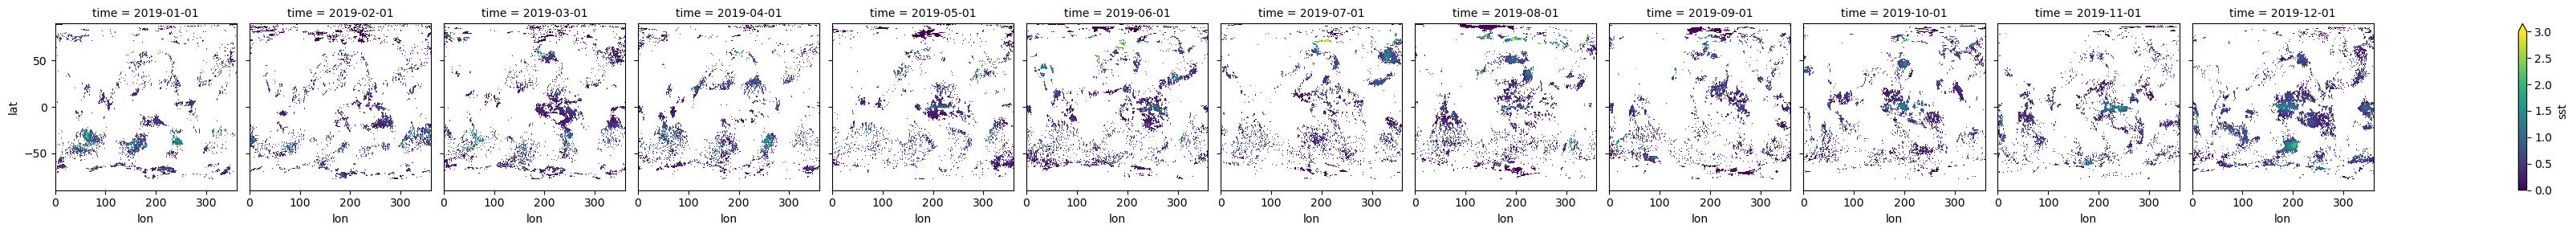

In [14]:
da_mhw.isel(time=slice(0,12)).plot(col='time',vmin=0,vmax=3)